In [1]:
# Cell 1 — Imports & paths
# Purpose: set up environment and output folders
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

project = Path(r"D:\SaaS Ticket Analytics Dashboard")
cleaned = project / "cleaned"
outputs = project / "outputs"
plots = outputs / "plots"

outputs.mkdir(parents=True, exist_ok=True)
plots.mkdir(parents=True, exist_ok=True)

print("Using cleaned folder:", cleaned)
print("Outputs folder:", outputs)


Using cleaned folder: D:\SaaS Ticket Analytics Dashboard\cleaned
Outputs folder: D:\SaaS Ticket Analytics Dashboard\outputs


In [2]:
# Cell 2 — Connect + Register tickets
# Purpose: load tickets CSV into DuckDB
con = duckdb.connect()

tickets_fp = cleaned / "tickets_master_clean.csv"
tickets = pd.read_csv(tickets_fp, parse_dates=['created_at'], low_memory=False)
con.register("tickets", tickets)

print("Tickets loaded:", tickets.shape)


Tickets loaded: (11000, 26)


In [3]:
# Cell 3 — Inspect columns
# Purpose: show columns to verify exact names for SQL
print("tickets columns:")
print(tickets.columns.tolist())


tickets columns:
['ticket_id', 'created_at', 'first_response_at', 'resolved_at', 'priority', 'status', 'issue_type', 'channel', 'customer_id', 'agent_id', 'first_response_mins', 'resolution_time_hours', 'sla_hours', 'sla_breached', 'reopened', 'escalated', 'csat', 'created_date', 'created_hour', 'created_weekday', 'agent_name', 'team', 'experience_years', 'customer_size', 'customer_segment', 'year_month']


In [4]:
# Cell 4 — KPI: Total Tickets
# Purpose: count total tickets via SQL
kpi_total = con.execute("SELECT COUNT(*) AS total_tickets FROM tickets;").df()
kpi_total

,total_tickets
0,11000


In [5]:
# Cell 5 — KPIs: averages and SLA %
# Purpose: avg first-response, avg resolution, sla breach %, avg csat
kpi_avg_fr = con.execute("SELECT AVG(first_response_mins) AS avg_first_response_mins FROM tickets;").df()
kpi_avg_res = con.execute("SELECT AVG(resolution_time_hours) AS avg_resolution_hrs FROM tickets;").df()
kpi_sla = con.execute("SELECT ROUND(AVG(sla_breached) * 100, 2) AS sla_breach_pct FROM tickets;").df()
kpi_csat = con.execute("SELECT ROUND(AVG(csat), 2) AS avg_csat FROM tickets;").df()

# display
kpi_avg_fr, kpi_avg_res, kpi_sla, kpi_csat


(   avg_first_response_mins
 0               260.394182,
    avg_resolution_hrs
 0           20.860154,
    sla_breach_pct
 0             0.0,
    avg_csat
 0      3.56)

In [8]:
# Cell 6 — Tickets per month (FIXED)
# Purpose: monthly trend table

monthly = con.execute("""
    SELECT 
        STRFTIME('%Y-%m', created_at) AS year_month,
        COUNT(*) AS total_tickets
    FROM tickets
    GROUP BY 1
    ORDER BY 1;
""").df()

monthly.to_csv(outputs / "sql_monthly_trend.csv", index=False)
monthly.head()


,year_month,total_tickets
0,2024-11,915
1,2024-12,946
2,2025-01,901
3,2025-02,842
4,2025-03,919


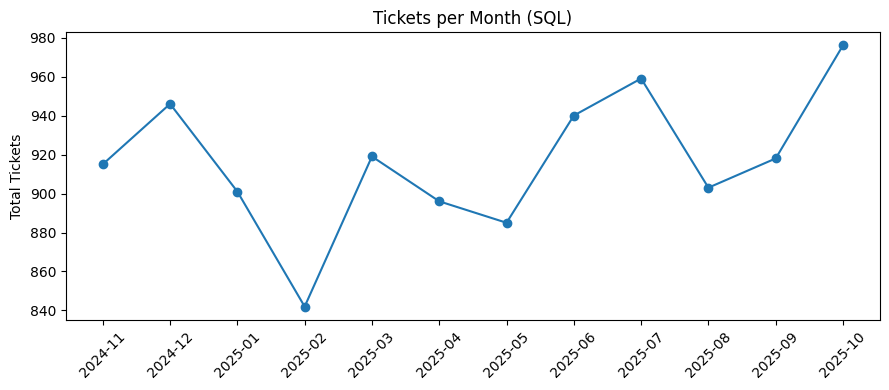

In [9]:
# Cell 7 — Plot monthly trend
# Purpose: plot monthly tickets trend and save image
plt.figure(figsize=(9,4))
plt.plot(monthly['year_month'], monthly['total_tickets'], marker='o')
plt.xticks(rotation=45)
plt.title("Tickets per Month (SQL)")
plt.ylabel("Total Tickets")
plt.tight_layout()
plt.savefig(plots / "sql_tickets_per_month.png", dpi=200)
plt.show()


In [11]:
# Cell 8 — SLA breach % by month (FIXED)
# Purpose: SLA breaches aggregated monthly

sla_month = con.execute("""
    SELECT 
        STRFTIME('%Y-%m', created_at) AS year_month,
        SUM(CASE WHEN sla_breached = 1 THEN 1 ELSE 0 END) AS sla_breaches,
        COUNT(*) AS total_tickets,
        ROUND(100.0 * SUM(CASE WHEN sla_breached = 1 THEN 1 ELSE 0 END) 
              / NULLIF(COUNT(*),0), 2) AS sla_breach_pct
    FROM tickets
    GROUP BY 1
    ORDER BY 1;
""").df()

sla_month.to_csv(outputs / "sql_sla_monthly.csv", index=False)
sla_month.head()



,year_month,sla_breaches,total_tickets,sla_breach_pct
0,2024-11,0.0,915,0.0
1,2024-12,0.0,946,0.0
2,2025-01,0.0,901,0.0
3,2025-02,0.0,842,0.0
4,2025-03,0.0,919,0.0


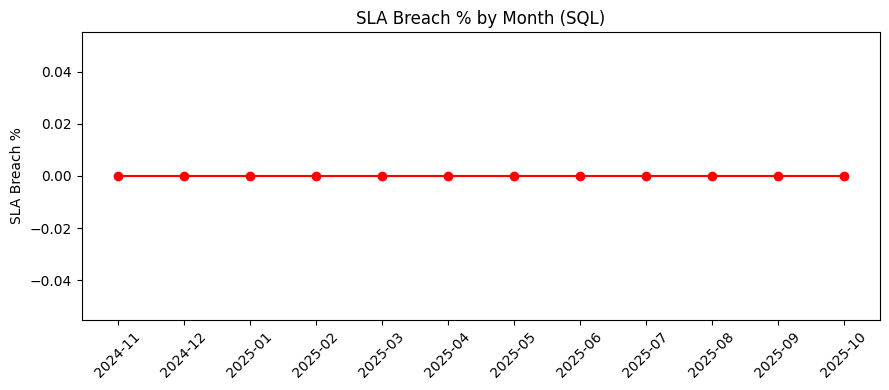

In [12]:
# Cell 9 — Plot SLA monthly trend
# Purpose: plot SLA breach %
plt.figure(figsize=(9,4))
plt.plot(sla_month['year_month'], sla_month['sla_breach_pct'], marker='o', color='red')
plt.xticks(rotation=45)
plt.title("SLA Breach % by Month (SQL)")
plt.ylabel("SLA Breach %")
plt.tight_layout()
plt.savefig(plots / "sql_sla_breach_trend.png", dpi=200)
plt.show()


In [13]:
# Cell 10 — Top 10 issue types
# Purpose: top issue categories
top_issues = con.execute("""
    SELECT issue_type, COUNT(*) AS total_tickets
    FROM tickets
    GROUP BY issue_type
    ORDER BY total_tickets DESC
    LIMIT 10;
""").df()

top_issues.to_csv(outputs / "sql_top_issue_types.csv", index=False)
top_issues


,issue_type,total_tickets
0,Api Failure,2020
1,Login Issue,1628
2,Data Mismatch,1318
3,Ui Bug,1280
4,Payroll Sync Error,1278
5,Integration Config,929
6,Permission Issue,912
7,Billing Query,867
8,Performance Issue,768


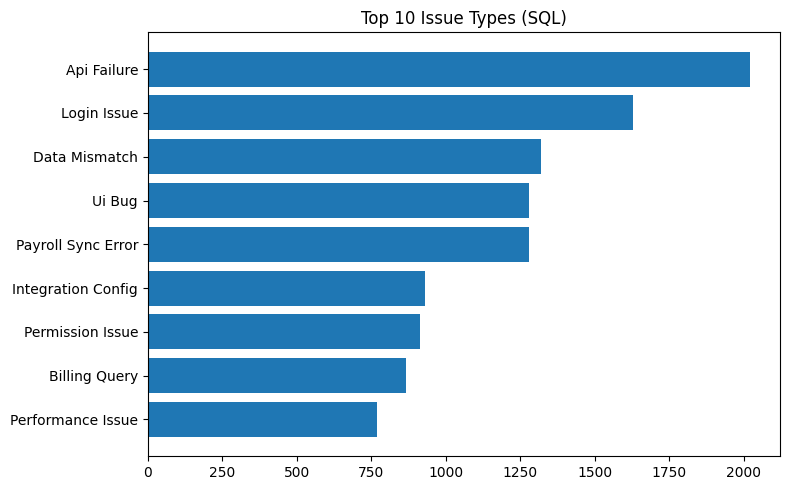

In [14]:
# Cell 11 — Plot top issue types
# Purpose: plot top 10 issue types
plt.figure(figsize=(8,5))
plt.barh(top_issues['issue_type'], top_issues['total_tickets'])
plt.gca().invert_yaxis()
plt.title("Top 10 Issue Types (SQL)")
plt.tight_layout()
plt.savefig(plots / "sql_top_issue_types.png", dpi=200)
plt.show()


In [15]:
# Cell 12 — Tickets by hour
# Purpose: tickets per hour (0-23)
tickets_hour = con.execute("""
    SELECT CAST(created_hour AS INTEGER) AS created_hour,
           COUNT(*) AS total_tickets
    FROM tickets
    GROUP BY created_hour
    ORDER BY created_hour;
""").df()

tickets_hour.to_csv(outputs / "sql_tickets_by_hour.csv", index=False)
tickets_hour.head()


,created_hour,total_tickets
0,0,479
1,1,470
2,2,482
3,3,453
4,4,470


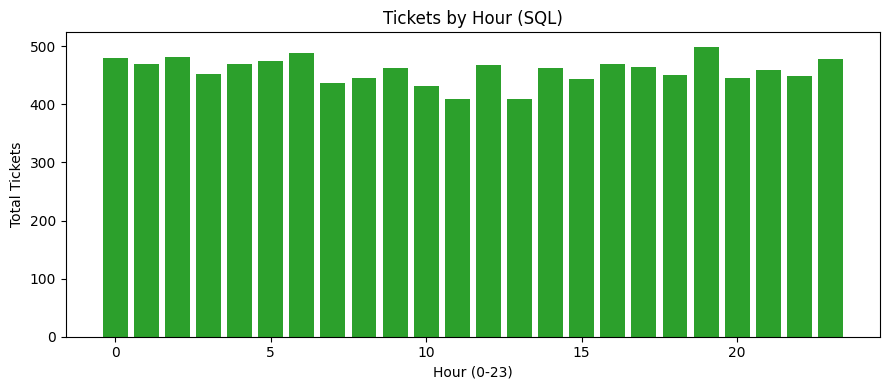

In [16]:
# Cell 13 — Plot tickets by hour
# Purpose: visualize hourly ticket volume
plt.figure(figsize=(9,4))
plt.bar(tickets_hour['created_hour'], tickets_hour['total_tickets'], color='C2')
plt.title("Tickets by Hour (SQL)")
plt.xlabel("Hour (0-23)")
plt.ylabel("Total Tickets")
plt.tight_layout()
plt.savefig(plots / "sql_tickets_by_hour.png", dpi=200)
plt.show()


In [17]:
# Cell 14 — Agent performance (top 10)
# Purpose: agent-level workload and performance metrics
agent_perf = con.execute("""
    SELECT agent_id, agent_name,
           COUNT(*) AS tickets_handled,
           ROUND(AVG(resolution_time_hours), 2) AS avg_resolution_hrs,
           ROUND(AVG(first_response_mins), 2) AS avg_first_response_mins,
           ROUND(AVG(csat), 2) AS avg_csat
    FROM tickets
    GROUP BY agent_id, agent_name
    ORDER BY tickets_handled DESC
    LIMIT 10;
""").df()

agent_perf.to_csv(outputs / "sql_agent_performance_top10.csv", index=False)
agent_perf


,agent_id,agent_name,tickets_handled,avg_resolution_hrs,avg_first_response_mins,avg_csat
0,A017,Agent_17,314,20.67,281.91,3.54
1,A013,Agent_13,309,20.87,264.75,3.58
2,A015,Agent_15,306,21.70,239.25,3.61
3,A010,Agent_10,301,21.59,235.93,3.57
4,A023,Agent_23,298,20.75,260.49,3.62
5,A019,Agent_19,295,19.72,263.29,3.51
6,A003,Agent_3,291,19.71,262.05,3.60
7,A016,Agent_16,290,21.52,255.23,3.55
8,A014,Agent_14,289,19.71,273.13,3.53
9,A036,Agent_36,287,19.76,255.41,3.56


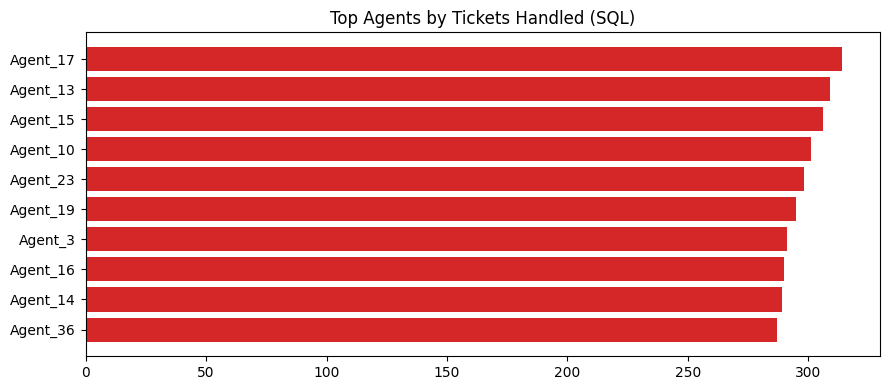

In [18]:
# Cell 15 — Plot top agents by tickets handled
# Purpose: plot top agents by ticket volume
plt.figure(figsize=(9,4))
plt.barh(agent_perf['agent_name'].astype(str), agent_perf['tickets_handled'], color='C3')
plt.gca().invert_yaxis()
plt.title("Top Agents by Tickets Handled (SQL)")
plt.tight_layout()
plt.savefig(plots / "sql_top_agents_by_tickets.png", dpi=200)
plt.show()


In [19]:
# Cell 16 — Save outputs & insights
# Purpose: save CSVs and write a short insights text
monthly.to_csv(outputs / "sql_monthly_trend.csv", index=False)
sla_month.to_csv(outputs / "sql_sla_monthly.csv", index=False)
top_issues.to_csv(outputs / "sql_top_issue_types.csv", index=False)
tickets_hour.to_csv(outputs / "sql_tickets_by_hour.csv", index=False)
agent_perf.to_csv(outputs / "sql_agent_performance_top10.csv", index=False)

insights = [
    f"Total tickets: {int(kpi_total['total_tickets'].iloc[0])}",
    f"Avg first response (mins): {float(kpi_avg_fr['avg_first_response_mins'].iloc[0]):.2f}" if not kpi_avg_fr.empty else "Avg first response: N/A",
    f"SLA breach % (avg): {float(kpi_sla['sla_breach_pct'].iloc[0]):.2f}" if not kpi_sla.empty else "SLA breach %: N/A"
]

with open(outputs / "sql_insights.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(insights))

print("Saved CSVs to:", outputs)
print("Saved plots to:", plots)
print("Saved insights to:", outputs / "sql_insights.txt")


Saved CSVs to: D:\SaaS Ticket Analytics Dashboard\outputs
Saved plots to: D:\SaaS Ticket Analytics Dashboard\outputs\plots
Saved insights to: D:\SaaS Ticket Analytics Dashboard\outputs\sql_insights.txt
